In [4]:
import pyedflib
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
import chart_studio.plotly as py
import networkx as nx
import sails
import connectivipy as cp
import collections
import itertools
from networkx.algorithms import community
import community

# Question 1
## 1.1

In [5]:
#read the data for eyes opened (EO)
f = pyedflib.EdfReader('S040R01.edf') #read the file
n = f.signals_in_file #number of signals (64)
signal_labels = f.getSignalLabels() #name of the signals
eo = np.zeros((n, f.getNSamples()[0])) #create a empty array
for i in np.arange(n):
    eo[i, :] = f.readSignal(i)  #fill up the arrays with the signal from the edf file

#read data for eyes closed (EC)
f = pyedflib.EdfReader('S040R02.edf')
ec = np.zeros((n, f.getNSamples()[0]))
for i in np.arange(n):
    ec[i, :] = f.readSignal(i)

We compute the connections with the PDC method

In [6]:
#fitting in the model for eo with method yule-walker
model_eo = cp.Mvar().fit(eo, method = "yw")

#compute PDC
eo_pdc=cp.conn.pdc_fun(model_eo[0],model_eo[1],fs = 160, resolution = 100)[10,:,:]
np.fill_diagonal(eo_pdc,0)

#find our threshold
density=0.2 #set the density to 0.2
n = eo_pdc.shape[0]  
num_edges = int((density*n*(n-1))/2)    
threshold = -np.sort(-eo_pdc, axis = None)[num_edges+1]

#adj_matrix
eo_adj = (eo_pdc > threshold).astype(int)

C:\Users\giuli\Anaconda3\lib\site-packages\connectivipy\mvar\fitting.py:267: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  req = np.vstack(rr_b[:, :, x].T for x in range(1, pmax+1))


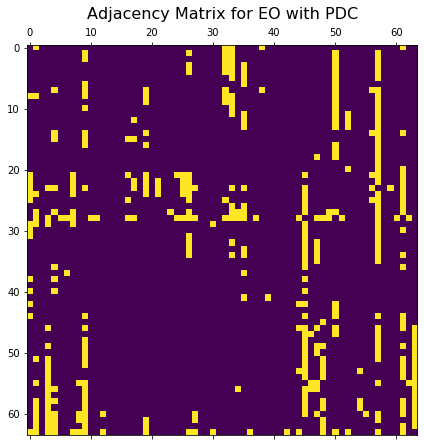

In [7]:
#let's see how the adjacency matrix looks like
f = plt.figure(figsize=(7, 7))
plt.matshow(eo_adj, fignum=f.number)
plt.title('Adjacency Matrix for EO with PDC', fontsize=16);

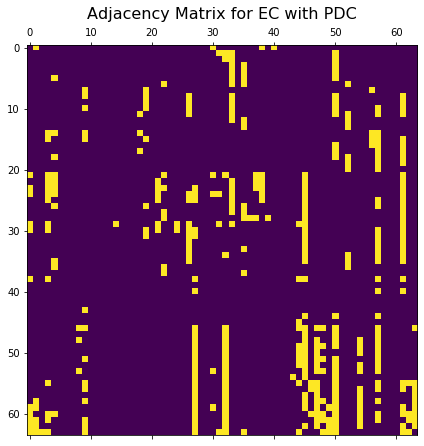

In [8]:
#let's do the same for EC
#fitting in the model for eo with method yule-walker
model_ec = cp.Mvar().fit(ec, method = "yw")

#compute PDC
ec_pdc=cp.conn.pdc_fun(model_ec[0],model_ec[1],fs = 160, resolution = 100)[10,:,:]
np.fill_diagonal(ec_pdc,0)

#find our threshold
density=0.2 #set the density to 0.2 
threshold = -np.sort(-ec_pdc, axis = None)[num_edges+1]

#adj_matrix
ec_adj = (ec_pdc > threshold).astype(int)

#plot the matrix
f = plt.figure(figsize=(7, 7))
plt.matshow(ec_adj, fignum=f.number)
plt.title('Adjacency Matrix for EC with PDC', fontsize=16);

## Question 1.2
let's repeat the same computation but with DTF instead of PDC

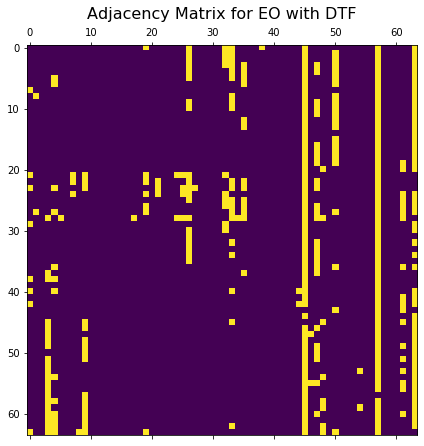

In [9]:
#compute DTF
eo_dtf=cp.conn.dtf_fun(model_eo[0],model_eo[1],fs = 160, resolution = 100)[10,:,:]
np.fill_diagonal(eo_dtf,0)

#find our threshold   
threshold = -np.sort(-eo_dtf, axis = None)[num_edges+1]

#adj_matrix
eo_adj_DTF = (eo_dtf > threshold).astype(int)

#plot
f = plt.figure(figsize=(7, 7))
plt.matshow(eo_adj_DTF, fignum=f.number)
plt.title('Adjacency Matrix for EO with DTF', fontsize=16);

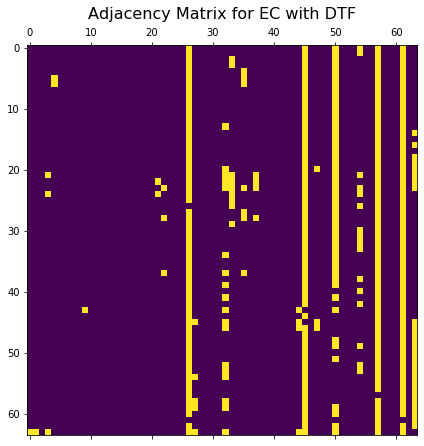

In [10]:
#compute DTF
ec_dtf=cp.conn.dtf_fun(model_ec[0],model_ec[1],fs = 160, resolution = 100)[10,:,:]
np.fill_diagonal(ec_dtf,0)

#find our threshold   
threshold = -np.sort(-ec_dtf, axis = None)[num_edges+1]

#adj_matrix
ec_adj_DTF = (ec_dtf > threshold).astype(int)

#plot
f = plt.figure(figsize=(7, 7))
plt.matshow(ec_adj_DTF, fignum=f.number)
plt.title('Adjacency Matrix for EC with DTF', fontsize=16);

## Question 1.3
let's repeat with different density values

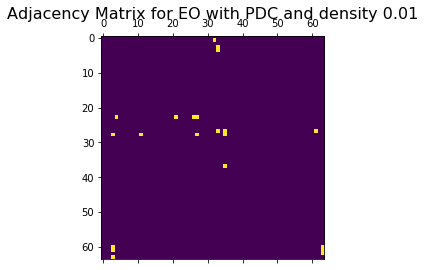

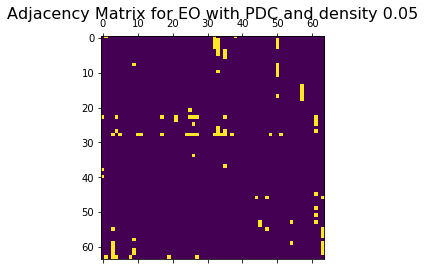

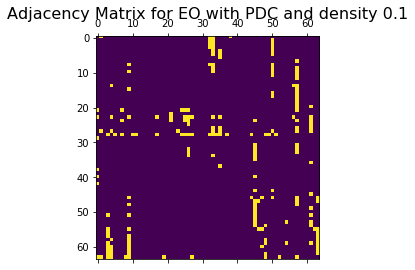

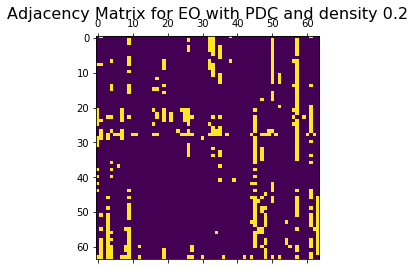

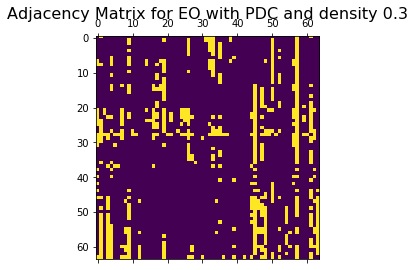

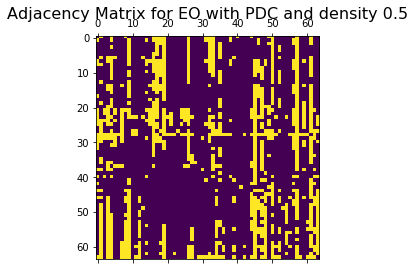

In [11]:
#let's repeat Question 1.1 with different density values
densities=[.01,.05,.1,.2,.3,.5]

#empty array to save matrix
eo_mtx=[]

for i in range(len(densities)):
    #recompute the values
    density=densities[i]
    num_edges = int((density*n*(n-1))/2)    
    threshold = -np.sort(-eo_pdc, axis = None)[num_edges+1]
    #adj_matrix
    temp_eo_adj = (eo_pdc > threshold).astype(int)
    eo_mtx.append(temp_eo_adj)
    #plot
    f = plt.figure(figsize=(4, 4))
    plt.matshow(temp_eo_adj, fignum=f.number)
    plt.title('Adjacency Matrix for EO with PDC and density '+str(densities[i]), fontsize=16);

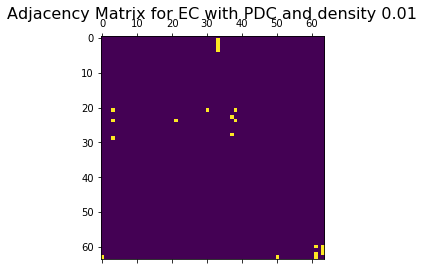

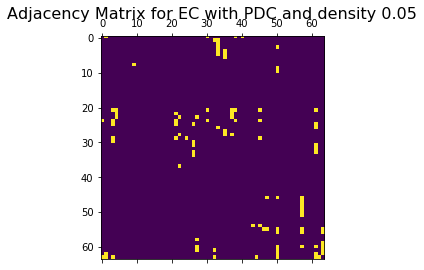

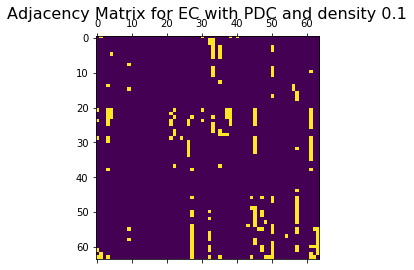

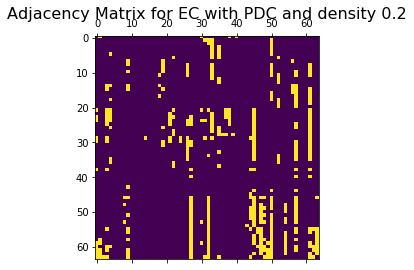

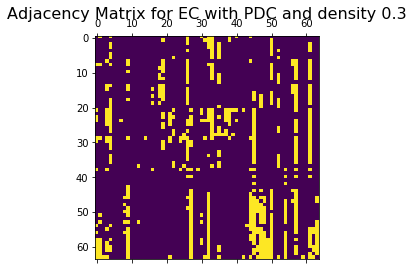

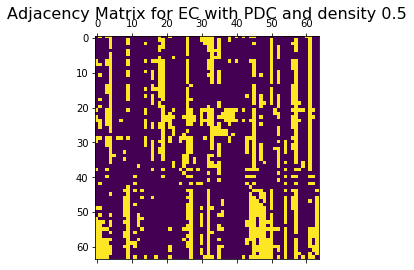

In [12]:
#same for EC

#empty array to save the matrix
ec_mtx=[]

for i in range(len(densities)):
    #recompute values
    density=densities[i]
    num_edges = int((density*n*(n-1))/2)    
    threshold = -np.sort(-ec_pdc, axis = None)[num_edges+1]
    #adj_matrix
    temp_ec_adj = (ec_pdc > threshold).astype(int)
    ec_mtx.append(temp_ec_adj)      #save the matrix in array
    #plot
    f = plt.figure(figsize=(4, 4))
    plt.matshow(temp_ec_adj, fignum=f.number)
    plt.title('Adjacency Matrix for EC with PDC and density '+str(densities[i]), fontsize=16);

## Question 1.5
we plot the graph down

C:\Users\giuli\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\giuli\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


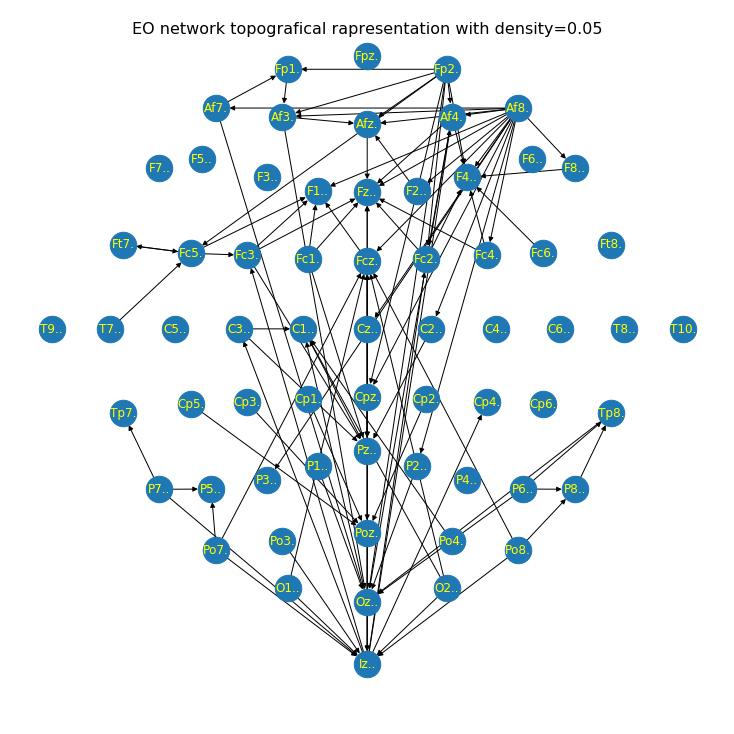

In [13]:
#create the graph with density 0.05
eo_g=nx.from_numpy_matrix(eo_mtx[1], create_using=nx.DiGraph)

#we need a dictionary with couples 0...64 and signal labels in order to rename the nodes of the graph
mapping={}
for i in range(len(signal_labels)):
    mapping[i]=signal_labels[i]
mapping


#let's rename them
eo_g=nx.relabel_nodes(eo_g, mapping)

#now give them a location 
#open the location file
position=pd.read_csv('channel_locations.txt', sep='\s+')

#create a pos dictionary to pass the position to the nodes of our graph
pos={}
for i in range(64):
    pos[position['label'][i]]=[position['x'][i],position['y'][i]]

#let's see our graph
f = plt.figure(figsize=(10, 10))
f.suptitle('EO network topografical rapresentation with density=0.05', fontsize=16)
nx.draw(eo_g, pos, node_size=700)
nx.draw_networkx_labels(eo_g, pos=pos, font_color='yellow')
plt.show()

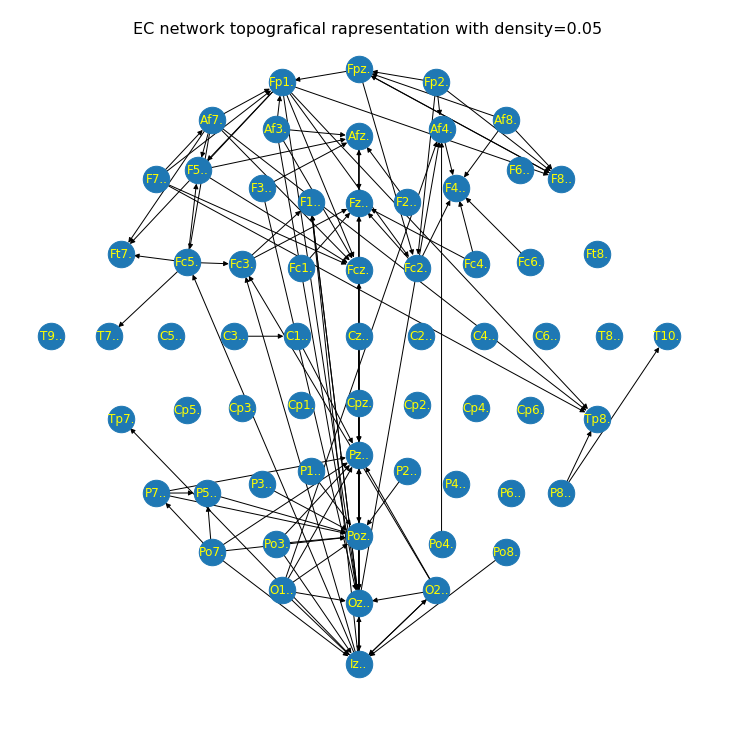

In [14]:
#same for EC

#create the graph
ec_g=nx.from_numpy_matrix(ec_mtx[1], create_using=nx.DiGraph)

#let's rename them
ec_g=nx.relabel_nodes(ec_g, mapping)

#let's see our graph
f = plt.figure(figsize=(10, 10))
f.suptitle('EC network topografical rapresentation with density=0.05', fontsize=16)
nx.draw(ec_g, pos, node_size=700)
nx.draw_networkx_labels(ec_g, pos=pos, font_color='yellow')
plt.show()

# Question 2
## 2.1

In [15]:
#we computed the adjacency matrix with different values for density and with both PDC and DTF
#we now will work with the ones with PDC and density =.20
# eo_adj=eo_mtx[3]
# ec_adj=ec_mtx[3]

#we recompute the graphs
eo_g=nx.from_numpy_matrix(eo_adj, create_using=nx.DiGraph)
ec_g=nx.from_numpy_matrix(ec_adj, create_using=nx.DiGraph)

#GLOBAL INDICES
#let's compute the clustering coefficent
eo_clus=nx.average_clustering(eo_g)
ec_clus=nx.average_clustering(ec_g)

#shortest path lenght

# eo_apl=nx.average_shortest_path_length(eo_g)
# ec_apl=nx.average_shortest_path_length(ec_g)

#we need to write the function from scratch because the graph is not weakly connected
G_un = nx.from_numpy_matrix(eo_adj)
connected_components = nx.connected_component_subgraphs(G_un)
subgraphs = map(lambda smallGraph : G_un.subgraph(smallGraph.nodes()), connected_components)
eo_apl = np.mean(list(map(lambda x: nx.average_shortest_path_length(x), subgraphs )))

G_un = nx.from_numpy_matrix(ec_adj)
connected_components = nx.connected_component_subgraphs(G_un)
subgraphs = map(lambda smallGraph : G_un.subgraph(smallGraph.nodes()), connected_components)
ec_apl = np.mean(list(map(lambda x: nx.average_shortest_path_length(x), subgraphs )))


#LOCAL INDICES
#degree
eo_deg=eo_g.degree()
ec_deg=ec_g.degree()

#In-degree
eo_Ideg=eo_g.in_degree()
ec_Ideg=ec_g.in_degree()

#Out-degree
eo_Odeg=eo_g.out_degree()
ec_Odeg=ec_g.out_degree()

In [16]:
print('For Eye-Open: clustering coefficient is ='+str(round(eo_clus,2))+' wile average path length is ='+str(round(eo_apl,2)))
print('For Eye-Closed: clustering coefficient is ='+str(round(ec_clus,2))+' wile average path length is ='+str(round(ec_apl,2)))

For Eye-Open: clustering coefficient is =0.26 wile average path length is =1.96
For Eye-Closed: clustering coefficient is =0.28 wile average path length is =0.65


In [17]:
#let's see top 10 nodes for local indices
#we order them, slice the first 10 and save into variables

#degree
top_eo_deg=sorted(dict(eo_deg).items(), key=lambda x: x[1], reverse=True)[:10]
top_ec_deg=sorted(dict(ec_deg).items(), key=lambda x: x[1], reverse=True)[:10]

#in
top_eo_Ideg=sorted(dict(eo_Ideg).items(), key=lambda x: x[1], reverse=True)[:10]
top_ec_Ideg=sorted(dict(ec_Ideg).items(), key=lambda x: x[1], reverse=True)[:10]

#out
top_eo_Odeg=sorted(dict(eo_Odeg).items(), key=lambda x: x[1], reverse=True)[:10]
top_ec_Odeg=sorted(dict(ec_Odeg).items(), key=lambda x: x[1], reverse=True)[:10]

Output for top 10 for EO

In [18]:
out=pd.DataFrame(top_eo_deg, columns=['Node','Degree'])
out['Node']=out.Node.map(mapping)
out

,Node,Degree
0,Poz.,48
1,Iz..,37
2,Oz..,36
3,Tp8.,34
4,C1..,31
5,Pz..,28
6,Af8.,26
7,Fcz.,24
8,Fz..,21
9,Fc3.,20


In [19]:
out=pd.DataFrame(top_eo_Ideg, columns=['Node','In-Degree'])
out['Node']=out.Node.map(mapping)
out

,Node,In-Degree
0,Poz.,44
1,Tp8.,32
2,C1..,26
3,Oz..,26
4,Pz..,23
5,Fcz.,18
6,Iz..,17
7,Fz..,16
8,Afz.,15
9,F4..,15


In [20]:
out=pd.DataFrame(top_eo_Odeg, columns=['Node','Out-Degree'])
out['Node']=out.Node.map(mapping)
out

,Node,Out-Degree
0,Af8.,26
1,Iz..,20
2,Fp2.,17
3,Af4.,13
4,O1..,13
5,Fp1.,11
6,Af7.,10
7,Oz..,10
8,Fpz.,9
9,P7..,9


Same for EC

In [21]:
out=pd.DataFrame(top_ec_deg, columns=['Node','Degree'])
out['Node']=out.Node.map(mapping)
out

,Node,Degree
0,Oz..,46
1,Poz.,40
2,Pz..,37
3,Tp8.,31
4,Af4.,30
5,F1..,26
6,Iz..,24
7,Fz..,23
8,Afz.,20
9,P5..,20


In [22]:
out=pd.DataFrame(top_ec_Ideg, columns=['Node','In-Degree'])
out['Node']=out.Node.map(mapping)
out

,Node,In-Degree
0,Poz.,33
1,Oz..,32
2,Tp8.,30
3,Pz..,30
4,Af4.,25
5,F1..,22
6,Fz..,18
7,P5..,15
8,Fcz.,14
9,C1..,14


In [23]:
out=pd.DataFrame(top_ec_Odeg, columns=['Node','Out-Degree'])
out['Node']=out.Node.map(mapping)
out

,Node,Out-Degree
0,Iz..,15
1,O1..,14
2,Oz..,14
3,Af7.,12
4,Po7.,12
5,Po8.,12
6,O2..,12
7,Fp2.,11
8,F7..,11
9,P7..,11


## 2.2
compute the small word index omega

In [24]:
"""ec_g=nx.from_numpy_matrix(ec_adj)
nx.sigma(ec_g)"""

'ec_g=nx.from_numpy_matrix(ec_adj)\nnx.sigma(ec_g)'

In [25]:
"""nx.omega(ec_g)"""

'nx.omega(ec_g)'

## 2.3

In [26]:
#compute the global indices for the network found with DTF instead that PDC

#compute the graphs
eo_g_DTF=nx.from_numpy_matrix(eo_adj_DTF, create_using=nx.DiGraph)
ec_g_DTF=nx.from_numpy_matrix(ec_adj_DTF, create_using=nx.DiGraph)

#compute the indices
#GLOBAL INDICES
#let's compute the clustering coefficent
eo_clus_DTF=nx.average_clustering(eo_g_DTF)
ec_clus_DTF=nx.average_clustering(ec_g_DTF)

#shortest path lenght
eo_apl_DTF=nx.average_shortest_path_length(eo_g_DTF)
ec_apl_DTF=nx.average_shortest_path_length(ec_g_DTF)

#print output
print('For Eye-Open: clustering coefficient is ='+str(round(eo_clus_DTF,2))+' wile average path length is ='+str(round(eo_apl_DTF,2)))
print('For Eye-Closed: clustering coefficient is ='+str(round(ec_clus_DTF,2))+' wile average path length is ='+str(round(ec_apl_DTF,2)))

For Eye-Open: clustering coefficient is =0.53 wile average path length is =0.6
For Eye-Closed: clustering coefficient is =0.64 wile average path length is =0.45


## 2.4

In [27]:
for i in range(len(eo_mtx)):
    temp_graph=nx.from_numpy_matrix(eo_mtx[i], create_using=nx.DiGraph)
    if nx.is_weakly_connected(temp_graph):
        temp_clus=nx.average_clustering(temp_graph)
        temp_apl=nx.average_shortest_path_length(temp_graph)
    else:
        temp_clus=nx.average_clustering(temp_graph)
        G_un = nx.from_numpy_matrix(eo_mtx[i])
        connected_components = nx.connected_component_subgraphs(G_un)
        subgraphs = map(lambda smallGraph : G_un.subgraph(smallGraph.nodes()), connected_components)
        temp_apl = np.mean(list(map(lambda x: nx.average_shortest_path_length(x), subgraphs )))
    print('For density ='+str(densities[i])+' the Average Clustering is ='+str(round(temp_clus,2))+' while Average Shortest Path Length is ='+str(round(temp_apl,2)), end="\n")

For density =0.01 the Average Clustering is =0.02 while Average Shortest Path Length is =0.07
For density =0.05 the Average Clustering is =0.08 while Average Shortest Path Length is =0.19
For density =0.1 the Average Clustering is =0.16 while Average Shortest Path Length is =0.39
For density =0.2 the Average Clustering is =0.26 while Average Shortest Path Length is =1.66
For density =0.3 the Average Clustering is =0.3 while Average Shortest Path Length is =2.3
For density =0.5 the Average Clustering is =0.39 while Average Shortest Path Length is =2.07


In [28]:
for i in range(len(ec_mtx)):
    temp_graph=nx.from_numpy_matrix(ec_mtx[i], create_using=nx.DiGraph)
    if nx.is_weakly_connected(temp_graph):
        temp_clus=nx.average_clustering(temp_graph)
        temp_apl=nx.average_shortest_path_length(temp_graph)
    else:
        temp_clus=nx.average_clustering(temp_graph)
        G_un = nx.from_numpy_matrix(ec_mtx[i])
        connected_components = nx.connected_component_subgraphs(G_un)
        subgraphs = map(lambda smallGraph : G_un.subgraph(smallGraph.nodes()), connected_components)
        temp_apl = np.mean(list(map(lambda x: nx.average_shortest_path_length(x), subgraphs )))
    print('For density ='+str(densities[i])+' the Average Clustering is ='+str(round(temp_clus,2))+' while Average Shortest Path Length is ='+str(round(temp_apl,2)), end="\n")

For density =0.01 the Average Clustering is =0.06 while Average Shortest Path Length is =0.11
For density =0.05 the Average Clustering is =0.12 while Average Shortest Path Length is =0.17
For density =0.1 the Average Clustering is =0.17 while Average Shortest Path Length is =0.3
For density =0.2 the Average Clustering is =0.28 while Average Shortest Path Length is =0.65
For density =0.3 the Average Clustering is =0.36 while Average Shortest Path Length is =0.89
For density =0.5 the Average Clustering is =0.42 while Average Shortest Path Length is =1.86


# 3
## 3.1

In [29]:
#Define every combination of motifs of 3 nodes by creating a graph of every of this motifs
motifs = {
    'S1': nx.DiGraph([(1,2),(2,3)]),
    'S2': nx.DiGraph([(1,2),(1,3),(2,3)]),
    'S3': nx.DiGraph([(1,2),(2,3),(3,1)]),
    'S4': nx.DiGraph([(1,2),(3,2)]),
    'S5': nx.DiGraph([(1,2),(1,3)])
    }

In [30]:
"""mcount = dict(zip(motifs.keys(), list(map(int, np.zeros(len(motifs))))))
nodes = eo_g.nodes()

    #We use iterools.product to have all combinations of three nodes in the
    #original graph. Then we filter combinations with non-unique nodes, because
    #the motifs do not account for self-consumption.

triplets = list(itertools.product(*[nodes, nodes, nodes]))
triplets = [trip for trip in triplets if len(list(set(trip))) == 3]
triplets = map(list, map(np.sort, triplets))
u_triplets = []
[u_triplets.append(trip) for trip in triplets if not u_triplets.count(trip)]

    #The for each each of the triplets, we (i) take its subgraph, and compare
    #it to all fo the possible motifs

for trip in u_triplets:
    sub_gr = eo_g.subgraph(trip)
    mot_match = map(lambda mot_id: nx.is_isomorphic(sub_gr, motifs[mot_id]), motifs.keys())
    match_keys = [mo.keys()[i] for i in range(len(motifs)) if mot_match[i]]
    if len(match_keys) == 1:
        mcount[match_keys[0]] += 1

mcount"""

'mcount = dict(zip(motifs.keys(), list(map(int, np.zeros(len(motifs))))))\nnodes = eo_g.nodes()\n\n    #We use iterools.product to have all combinations of three nodes in the\n    #original graph. Then we filter combinations with non-unique nodes, because\n    #the motifs do not account for self-consumption.\n\ntriplets = list(itertools.product(*[nodes, nodes, nodes]))\ntriplets = [trip for trip in triplets if len(list(set(trip))) == 3]\ntriplets = map(list, map(np.sort, triplets))\nu_triplets = []\n[u_triplets.append(trip) for trip in triplets if not u_triplets.count(trip)]\n\n    #The for each each of the triplets, we (i) take its subgraph, and compare\n    #it to all fo the possible motifs\n\nfor trip in u_triplets:\n    sub_gr = eo_g.subgraph(trip)\n    mot_match = map(lambda mot_id: nx.is_isomorphic(sub_gr, motifs[mot_id]), motifs.keys())\n    match_keys = [mo.keys()[i] for i in range(len(motifs)) if mot_match[i]]\n    if len(match_keys) == 1:\n        mcount[match_keys[0]] += 1\n

# 4
## 4.1

In [34]:
community.best_partition(G_un)

{0: 0,
 1: 1,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 2,
 8: 1,
 9: 1,
 10: 2,
 11: 2,
 12: 2,
 13: 2,
 14: 2,
 15: 2,
 16: 2,
 17: 2,
 18: 2,
 19: 2,
 20: 2,
 21: 0,
 22: 0,
 23: 0,
 24: 0,
 25: 0,
 26: 2,
 27: 1,
 28: 0,
 29: 0,
 30: 0,
 31: 2,
 32: 1,
 33: 0,
 34: 2,
 35: 0,
 36: 0,
 37: 0,
 38: 0,
 39: 0,
 40: 2,
 41: 3,
 42: 1,
 43: 1,
 44: 1,
 45: 1,
 46: 1,
 47: 1,
 48: 1,
 49: 1,
 50: 1,
 51: 1,
 52: 2,
 53: 1,
 54: 1,
 55: 1,
 56: 1,
 57: 2,
 58: 1,
 59: 1,
 60: 1,
 61: 2,
 62: 1,
 63: 1}